In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [210]:
import warnings
warnings.filterwarnings("ignore")

In [224]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

In [225]:
py_file_location = "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE"
sys.path.append(os.path.abspath(py_file_location))

In [227]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF

# Train

Encoding Process

In [8]:
train_df, test_df = get_train_test_pd()
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=512)
print('begin encoding')
f = lambda text: bert_model.encode([text])["encodes"][0]

train_df['x'] = train_df['text'].apply(f)
test_df['x'] = test_df['text'].apply(f)
print('end encoding')

I:PROCESS:[graph:opt: 49]:model config: /content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: /content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/tmp_graph11


begin encoding
end encoding


Training and Test Set

In [228]:
x_train = np.array([vec for vec in train_df['x']])
x_test = np.array([vec for vec in test_df['x']])
y_train = np.array([vec for vec in train_df['label']])
y_test = np.array([vec for vec in test_df['label']])

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

x_train:  (1046, 512, 768)
y_train:  (1046,)
x_test:  (261, 512, 768)
y_test:  (261,)


In [229]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [230]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [231]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)

Size of training input data :  (1046, 512, 768)
Size of training output data :  (1046, 4)
Size of testing input data :  (261, 512, 768)
Size of testing output data :  (261, 4)


Model Config

In [232]:
inputs = Input(name="Input", shape=(512, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [233]:
# If there are .hdf5 files in the original models folder, delete them all
model_dir = '/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output'
if os.listdir(model_dir):
    for file in os.listdir(model_dir):
        os.remove(os.path.join(model_dir, file))

Model Visualization

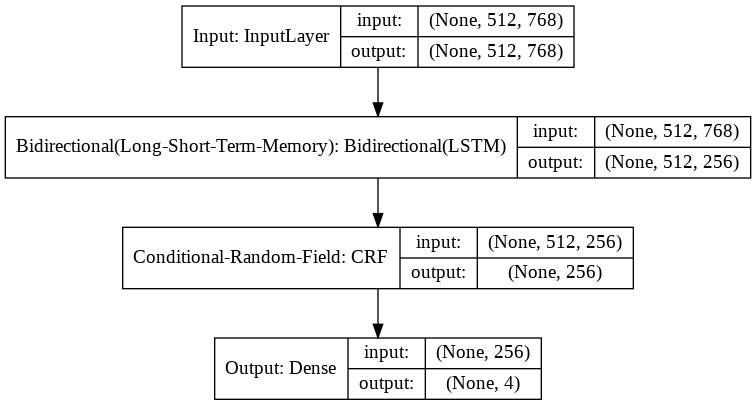

In [234]:
plot_model(model, to_file='/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/model.png', show_shapes=True)

Model Process

In [235]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 512, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 512, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1540      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 921,096
Trainable params: 921,096
Non-trainable params: 0
_________________________________________________________________


In [237]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [238]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

In [239]:
# Save the latest val_acc best model file
filepath="/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [240]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=8, 
    epochs=100, 
    callbacks=[checkpoint]) 
    # callbacks=[early_stopping, checkpoint])

Train on 1046 samples, validate on 261 samples
Epoch 1/100
1046/1046 [==============================] - 182s 174ms/step - loss: 1.0761 - accuracy: 0.4847 - val_loss: 1.0169 - val_accuracy: 0.5441

Epoch 00001: val_accuracy improved from -inf to 0.54406, saving model to /content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-01-0.5441.hdf5
Epoch 2/100
1046/1046 [==============================] - 158s 151ms/step - loss: 0.9328 - accuracy: 0.5746 - val_loss: 0.9262 - val_accuracy: 0.6015

Epoch 00002: val_accuracy improved from 0.54406 to 0.60153, saving model to /content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-02-0.6015.hdf5
Epoch 3/100
1046/1046 [==============================] - 151s 145ms/step - loss: 0.8044 - accuracy: 0.6530 - val_loss: 0.7894 - val_accuracy: 0.6475

Epoch 00003: val_accuracy improved from 0.60153 to 0.64751, saving model to /content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-03-0.6475.hdf5
Epoch 4/100
1046/1046 [===============

In [241]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

261/261 [==============================] - 8s 31ms/step
The effect on the test set： [0.9740330190950883, 0.7471264600753784]


In [242]:
with open('/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [243]:
y_pred = model.predict(x_test, batch_size=8)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.76      0.70      0.73       118
    Cause_of_disease       0.58      0.68      0.63        37
Treatment_of_disease       0.79      0.86      0.82        98
         Association       1.00      0.38      0.55         8

            accuracy                           0.75       261
           macro avg       0.78      0.65      0.68       261
        weighted avg       0.75      0.75      0.75       261



model 1

In [ ]:
model = load_model(
  "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-01-0.5939.hdf5", 
  custom_objects={"Attention": Attention})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.57      0.76      0.65       118
    Cause_of_disease       0.00      0.00      0.00        37
Treatment_of_disease       0.63      0.66      0.65        98
         Association       0.00      0.00      0.00         8

            accuracy                           0.59       261
           macro avg       0.30      0.36      0.32       261
        weighted avg       0.49      0.59      0.54       261



model 2

In [ ]:
model = load_model(
  "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-02-0.6092.hdf5", 
  custom_objects={"Attention": Attention})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.67      0.46      0.54       118
    Cause_of_disease       0.42      0.38      0.40        37
Treatment_of_disease       0.62      0.93      0.74        98
         Association       0.00      0.00      0.00         8

            accuracy                           0.61       261
           macro avg       0.43      0.44      0.42       261
        weighted avg       0.59      0.61      0.58       261



model 3

In [ ]:
model = load_model(
  "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-03-0.7165.hdf5", 
  custom_objects={"Attention": Attention})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.69      0.75      0.72       118
    Cause_of_disease       0.74      0.46      0.57        37
Treatment_of_disease       0.75      0.84      0.79        98
         Association       0.00      0.00      0.00         8

            accuracy                           0.72       261
           macro avg       0.54      0.51      0.52       261
        weighted avg       0.70      0.72      0.70       261



model 4

In [ ]:
model = load_model(
  "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-07-0.7471.hdf5", 
  custom_objects={"Attention": Attention})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.74      0.71      0.73       118
    Cause_of_disease       0.62      0.68      0.65        37
Treatment_of_disease       0.80      0.88      0.83        98
         Association       0.00      0.00      0.00         8

            accuracy                           0.75       261
           macro avg       0.54      0.57      0.55       261
        weighted avg       0.72      0.75      0.73       261



model 5

In [ ]:
model = load_model(
  "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-11-0.7739.hdf5", 
  custom_objects={"Attention": Attention})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.78      0.72      0.75       118
    Cause_of_disease       0.68      0.73      0.70        37
Treatment_of_disease       0.80      0.92      0.86        98
         Association       0.00      0.00      0.00         8

            accuracy                           0.77       261
           macro avg       0.56      0.59      0.58       261
        weighted avg       0.75      0.77      0.76       261



model 6

In [ ]:
model = load_model(
  "/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/per-rel-71-0.7816.hdf5", 
  custom_objects={"Attention": Attention})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.76      0.78      0.77       118
    Cause_of_disease       0.68      0.76      0.72        37
Treatment_of_disease       0.86      0.85      0.85        98
         Association       0.50      0.12      0.20         8

            accuracy                           0.78       261
           macro avg       0.70      0.63      0.63       261
        weighted avg       0.78      0.78      0.78       261



Chart Loss and Accuracy

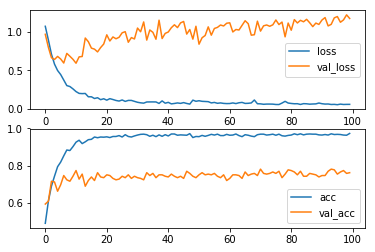

In [ ]:
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig("/content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/output/loss_acc.png")

# Predict

In [ ]:
! python /content/drive/MyDrive/Rearch_Dimas/BILSTM_CRF_RE/model_predict.py

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 